In [1]:
import os
import sys
import csv
import math
import random
import numpy as np
import cv2
# import json
import matplotlib
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf

warnings.filterwarnings('ignore')

print(tf.__version__)

# Root directory of the project
ROOT_DIR = os.getcwd()

from mrcnn.config import Config
from mrcnn import model as modellib,utils
from mrcnn import visualize
from mrcnn.model import log
from PIL import Image

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR,"logs")

iter_num = 0

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR,"mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/fzi/ids/fn875/.local/share/virtualenvs/pipenv_project-P3s74Nb0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/fzi/ids/fn875/.local/share/virtualenvs/pipenv_project-P3s74Nb0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/fzi/ids/fn875/.local/share/virtualenvs/pipenv_project-P3s74Nb0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint

1.14.0


Using TensorFlow backend.


In [11]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 15  # background +  shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 320 # 128
    IMAGE_MAX_DIM = 384 # 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8 *6, 16*6, 32*6, 64*6, 128*6)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                28
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [12]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


In [14]:
class BlockDataset(utils.Dataset):
    
    # read txt.file to get labels and mask              
    def get_class(self, image_id):
        '''
        info = self.image_info[image_id]
        with open("all_labels.json") as f:
            temp = json.load(f)
            labels = temp[info]['regions'][1]['region_attributes']['label']
        '''
        
        info = self.image_info[image_id]
        index = info['label_index']
        '''
        file = open('mask_index.txt','r')
        all_labels = file.readlines()
        labelstr = all_labels[int(index)-1] # This is a sting '[...]' !!
        labels = labelstr[1:-2].split(',')
        
        return labels
        '''
        data = open('dataset_generator/new_labels.csv','r')
        all_labels = csv.reader(data)
        labels = []
        for item in all_labels:
            if all_labels.line_num == 1:
                continue
            if item[0] == index:
                labels.append(item[1])

        # labelstr = all_labels[int(index)-1] # This is a sting '[...]' !!
        # labels = labelstr[1:-2].split(',') 
        return labels
    
    # draw_mask
    '''
    def draw_mask(self,num_obj,mask,image,image_id,labels_form):
        # The gray value if input mask_image(gray image) are the order of the classes 1, 2, 3...
        info = self.image_info[image_id]
        for index in range(num_obj):
            for i in range(info['width']):
                for j in range(info['height']):
                    at_pixel = image.getpixel((i,j))
                    if at_pixel == index + 1:
                        mask [j,i,index] = 1
            
        return mask
    '''
    
    def drawMask(self,image_id):
        info = self.image_info[image_id]
        masklist = os.listdir(info['mask_path'])
        # print(imglist)
        num_obj = len(masklist)
        mask = np.zeros([info['height'],info['width'],num_obj], dtype = np.uint8)
        # mask = np.zeros([info['height'],info['width']], dtype = np.uint8)
        maskArray = []
        for index in range(num_obj):
            img = Image.open(info['mask_path']+ '/mask%s.png' % (index+1))
            #imgArray = np.array(img,dtype=np.uint8)
            #maskArray.append(imgArray)
        # mask = np.array(maskArray,dtype=np.uint8)
            # mask = np.concatenate((mask, np.array(img, dtype = np.uint8)[:],axis = 2)
            for i in range(info['width']):
                for j in range(info['height']):
                   if img.getpixel((i,j)) == 1:
                        mask [j,i,index] = 1                    
        
        return mask
       
        
    def load_shapes(self,count,img_folder,mask_folder,imglist,dataset_root_path):
        # Add classes
        '''
        self.add_class("shapes",1,"large")
        self.add_class("shapes",2,"medium")
        self.add_class("shapes",3,"small")
        '''
        # "red_s","red_m","red_l","yellow_s","yellow_m","yellow_l","green_s",
        # "green_m","green_l","blue_s","blue_m","blue_l","orange_s","orange_m","orange_l"
        
        self.add_class("shapes",1,"red_s")
        self.add_class("shapes",2,"red_m")
        self.add_class("shapes",3,"red_l")
        self.add_class("shapes",4,"yellow_s")
        self.add_class("shapes",5,"yellow_m")
        self.add_class("shapes",6,"yellow_l")
        self.add_class("shapes",7,"green_s")
        self.add_class("shapes",8,"green_m")
        self.add_class("shapes",9,"green_l")
        self.add_class("shapes",10,"blue_s")
        self.add_class("shapes",11,"blue_m")
        self.add_class("shapes",12,"blue_l")
        self.add_class("shapes",13,"orange_s")
        self.add_class("shapes",14,"orange_m")
        self.add_class("shapes",15,"orange_l")
        
        
        for i in range(count):
            filestr = imglist[i].split(".")[0]
            # print(filestr)
            mask_path = mask_folder +"/image%s" % filestr
            label_index = filestr
            path2Img = img_folder+ "/%s.png" % filestr
            # print(path2Img)
            cv_img = cv2.imread(path2Img)
            # print(cv_img)
            # resize_img = cv2.resize(cv_img,(384,384),interpolation = cv2.INTER_AREA)
            self.add_image("shapes",image_id = i, path = path2Img,
                            width = cv_img.shape[1],height = cv_img.shape[0],mask_path = mask_path, label_index = label_index)
    
            
    
    def load_image(self, image_id):
        info = self.image_info[image_id]
        img = cv2.imread(info['path'])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        # resize_img = cv2.resize(img,(384,384),interpolation = cv2.INTER_AREA)
        return img
    
    
    def load_mask(self,image_id):
        global iter_num
        info = self.image_info[image_id]
        # Mask of instance individual or not????
        # masklist = os.listdir(info['mask_path'])
        # print(imglist)
        # num_obj = len(masklist)
        # img = Image.open(info['mask_path']+ mask1)
        
        # print(info['mask_path'])
        # num_obj = np.max(img)
        # print('num_obj--->',num_obj)

        labels = []
        labels = self.get_class(image_id)
        # print(labels)
        class_ids = np.array([self.class_names.index(s) for s in labels])
        # labels_form = []
        '''
        for i in range(len(labels)):
            if labels[i].find("_l") != -1:
                labels_form.append("large")
            elif labels[i].find("_m") != -1:
                labels_form.append("medium")
            else:
                labels_form.append("small")
        class_ids = np.array([self.class_names.index(s) for s in labels_form])
        
        if 1 in class_ids:
            idx = np.where(class_ids==1)[0][0]
            class_ids[0], class_ids[idx] = class_ids[idx], class_ids[0]
        if 2 in class_ids:
            idx = np.where(class_ids==2)[0][0]
            class_ids[1], class_ids[idx] = class_ids[idx], class_ids[1]
        if 3 in class_ids:
            idx = np.where(class_ids==3)[0][0]
            class_ids[2], class_ids[idx] = class_ids[idx], class_ids[2]
        '''
            
        # The number of instances of each picture
        # num_obj = len(class_ids)
        num_obj = np.max(class_ids)
        # print('num_obj--->',num_obj)
        # mask = np.zeros([info['height'],info['width'],num_obj], dtype = np.uint8)
        # mask = self.draw_mask(num_obj,mask,img,image_id,labels_form)
        mask = self.drawMask(image_id)
        
        '''
        occlusion = np.logical_not(mask[:,:,-1]).astype(np.uint8)
        for i in range(num_obj-2,-1,-1):
            mask[:,:,i] *= occlusion
            occlusion = np.logical_and(occlusion,np.logical_not(mask[:,:,i]))
        '''
        # print('-----END')
        
        return mask.astype(np.bool),class_ids.astype(np.int32)

In [15]:
# initialization
dataset_root_path = "dataset_generator/"
img_folder = dataset_root_path + "labeled_images/train"
mask_folder = dataset_root_path + "mask"
imglist = os.listdir(img_folder)
#print(imglist)
#count = len(imglist)
# print(count)
train_count = 800
val_count = 200

# traning data and validation data
dataset_train = BlockDataset()
dataset_train.load_shapes(train_count,img_folder,mask_folder,imglist,dataset_root_path)
dataset_train.prepare()
# print("dataset_train-->",dataset_train._image_ids)
# print('-----',dataset_train.get_class(dataset_train.image_ids[0]))

val_dataset_root_path = "dataset_generator/"
val_img_folder = val_dataset_root_path + "labeled_images/val"
val_mask_folder = val_dataset_root_path + "mask"
val_imglist = os.listdir(val_img_folder)

dataset_val = BlockDataset()
dataset_val.load_shapes(val_count,val_img_folder,val_mask_folder,val_imglist,val_dataset_root_path)
dataset_val.prepare()
# print("dataset_val-->",dataset_val._image_ids)


['yellow_s', 'blue_m', 'blue_m', 'yellow_s']
[ 4 11 11  4]


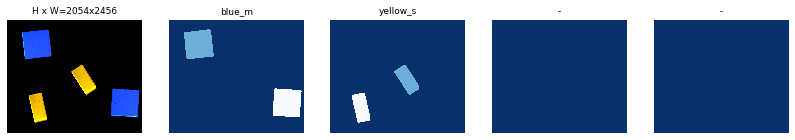

['green_l', 'orange_l']
[ 9 15]


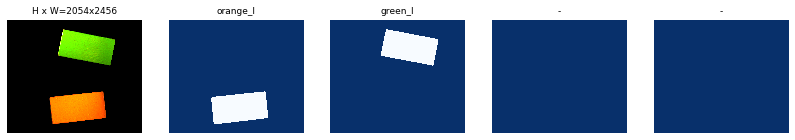

['orange_s', 'blue_m', 'green_l', 'red_s']
[13 11  9  1]


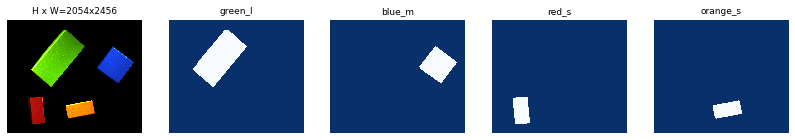

['green_l', 'blue_l', 'red_s']
[ 9 12  1]


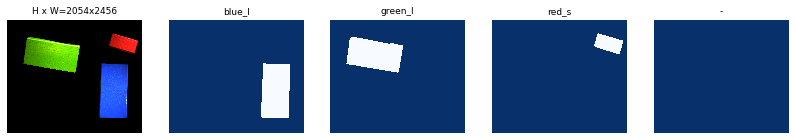

In [14]:
# Load and display random samples

image_ids = np.random.choice(dataset_train.image_ids,4)

for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask,class_ids = dataset_train.load_mask(image_id)
    print(class_ids)
    visualize.display_top_masks(image,mask,class_ids,dataset_train.class_names)





In [15]:
# create model in training model
model = modellib.MaskRCNN(mode="training",config = config ,model_dir = MODEL_DIR)

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last
if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [16]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')  


Starting at epoch 0. LR=0.001

Checkpoint Path: /disk/no_backup/fn875/xzc/pipenv_project/Mask_RCNN/AL_test/logs/shapes20200224T2143/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_con

ValueError: Error when checking input: expected input_image_meta to have shape (16,) but got array with shape (28,)

['orange_s', 'orange_m', 'red_l']
['orange_s', 'orange_m', 'red_l']
['orange_s', 'orange_m', 'red_l']
['orange_s', 'orange_m', 'red_l']
['orange_s', 'orange_m', 'red_l']
['orange_s', 'orange_m', 'red_l']
['blue_l', 'red_l', 'blue_m']
['orange_s', 'orange_m', 'red_l']
['blue_l', 'red_l', 'blue_m']
['blue_l', 'red_l', 'blue_m']
['blue_l', 'red_l', 'blue_m']
['blue_l', 'red_l', 'blue_m']
['blue_l', 'red_l', 'blue_m']
['blue_l', 'red_l', 'blue_m']
['blue_l', 'red_l', 'blue_m']
['orange_s', 'orange_m', 'red_l']
['orange_s', 'orange_m', 'red_l']
['blue_l', 'red_l', 'blue_m']
['blue_l', 'red_l', 'blue_m']
['blue_l', 'red_l', 'blue_m']
['orange_s', 'orange_m', 'red_l']
['blue_l', 'red_l', 'blue_m']
['orange_s', 'orange_m', 'red_l']
['orange_s', 'orange_m', 'red_l']
['green_s', 'blue_m', 'green_m', 'blue_l']
['green_s', 'blue_m', 'green_m', 'blue_l']
['green_s', 'blue_m', 'green_m', 'blue_l']
['green_s', 'blue_m', 'green_m', 'blue_l']
['green_s', 'blue_m', 'green_m', 'blue_l']
['green_s', 'blue

['orange_l', 'red_s', 'blue_s']
['orange_l', 'red_s', 'blue_s']
['orange_l', 'red_s', 'blue_s']
['orange_l', 'red_s', 'blue_s']
['orange_l', 'red_s', 'blue_s']
['orange_l', 'red_s', 'blue_s']
['orange_l', 'red_s', 'blue_s']
['orange_l', 'red_s', 'blue_s']
['orange_l', 'red_s', 'blue_s']
['red_l', 'yellow_s', 'red_m']
['orange_l', 'red_s', 'blue_s']
['red_l', 'yellow_s', 'red_m']
['red_l', 'yellow_s', 'red_m']
['red_l', 'yellow_s', 'red_m']
['red_l', 'yellow_s', 'red_m']
['red_l', 'yellow_s', 'red_m']
['red_l', 'yellow_s', 'red_m']
['red_m', 'green_l', 'red_m']
['red_l', 'yellow_s', 'red_m']
['red_m', 'green_l', 'red_m']
['red_l', 'yellow_s', 'red_m']
['red_l', 'yellow_s', 'red_m']
['red_l', 'yellow_s', 'red_m']
['red_l', 'yellow_s', 'red_m']
['red_m', 'green_l', 'red_m']
['red_m', 'green_l', 'red_m']
['red_m', 'green_l', 'red_m']
['red_m', 'green_l', 'red_m']
['red_m', 'green_l', 'red_m']
['red_m', 'green_l', 'red_m']
['red_m', 'green_l', 'red_m']
['red_m', 'green_l', 'red_m']
['red_m'

In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")  


Starting at epoch 1. LR=0.0001

Checkpoint Path: /disk/no_backup/fn875/xzc/pipenv_project/Mask_RCNN/AL_test/logs/shapes20200207T1559/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3

num_obj---> 3
num_obj---> 3
num_obj---> 3
num_obj---> 5
num_obj---> 5
num_obj---> 3
num_obj---> 5
num_obj---> 5
num_obj---> 3
num_obj---> 5
num_obj---> 3
num_obj---> 3
num_obj---> 3
num_obj---> 3
num_obj---> 3
num_obj---> 3
num_obj---> 5
num_obj---> 3
num_obj---> 5
num_obj---> 5
num_obj---> 5
num_obj---> 5
num_obj---> 5
num_obj---> 5
num_obj---> 5
num_obj---> 5
num_obj---> 5
num_obj---> 5
num_obj---> 5
num_obj---> 5
num_obj---> 5
num_obj---> 5
num_obj---> 5
num_obj---> 5
num_obj---> 5
num_obj---> 5
Epoch 2/2
num_obj---> 3
num_obj---> 3
num_obj---> 3
num_obj---> 3
num_obj---> 3
num_obj---> 3
num_obj---> 3
num_obj---> 3
num_obj---> 3
num_obj---> 3
num_obj---> 3
num_obj---> 3
num_obj---> 5
num_obj---> 3
num_obj---> 3
num_obj---> 5
num_obj---> 3
num_obj---> 3
num_obj---> 3
num_obj---> 3
num_obj---> 3
num_obj---> 5
num_obj---> 5
num_obj---> 5
num_obj---> 5
num_obj---> 3
num_obj---> 5
num_obj---> 5
num_obj---> 5
num_obj---> 5
num_obj---> 3
num_obj---> 5
num_obj---> 5
num_obj---> 3
num_obj---

 81/100 [=======================>......] - ETA: 4:02 - loss: 1.3698 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.2217 - mrcnn_class_loss: 0.4000 - mrcnn_bbox_loss: 0.4739 - mrcnn_mask_loss: 0.2558num_obj---> 5
num_obj---> 5
num_obj---> 5
num_obj---> 3
num_obj---> 3
num_obj---> 3
 82/100 [=======================>......] - ETA: 3:52 - loss: 1.3621 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.2207 - mrcnn_class_loss: 0.3974 - mrcnn_bbox_loss: 0.4705 - mrcnn_mask_loss: 0.2553num_obj---> 3
num_obj---> 3
num_obj---> 3
num_obj---> 3
num_obj---> 3
 83/100 [=======================>......] - ETA: 3:38 - loss: 1.3544 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.2196 - mrcnn_class_loss: 0.3947 - mrcnn_bbox_loss: 0.4671 - mrcnn_mask_loss: 0.2550num_obj---> 3
num_obj---> 3
num_obj---> 3
num_obj---> 3
 86/100 [========================>.....] - ETA: 2:57 - loss: 1.3295 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.2164 - mrcnn_class_loss: 0.3855 - mrcnn_bbox_loss: 0.4567 - mrcnn_mask_loss: 0.2535num_obj---

185
original_image           shape: (384, 384, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (28,)                 min:    0.00000  max: 2456.00000  float64
gt_class_id              shape: (4,)                  min:    2.00000  max:   15.00000  int32
gt_bbox                  shape: (4, 4)                min:   11.00000  max:  381.00000  int32
gt_mask                  shape: (384, 384, 4)         min:    0.00000  max:    1.00000  bool


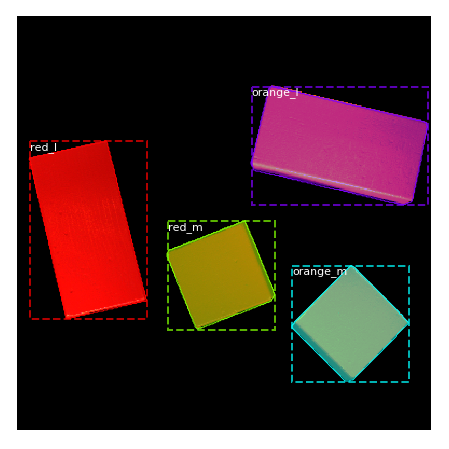

In [16]:
image_id = random.choice(dataset_val.image_ids)
print(image_id)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

1.14.0
Loading weights from  /disk/no_backup/fn875/xzc/pipenv_project/Mask_RCNN/AL_test/logs/shapes20200225T1356/mask_rcnn_shapes_0010.h5
Re-starting from epoch 10
Processing 1 images
image                    shape: (2054, 2456, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 384, 384, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max: 2456.00000  float64
anchors                  shape: (1, 36828, 4)         min:   -1.41791  max:    2.25080  float32
Time 5
[0.9835772  0.9508152  0.92313236]
[15  3  7]


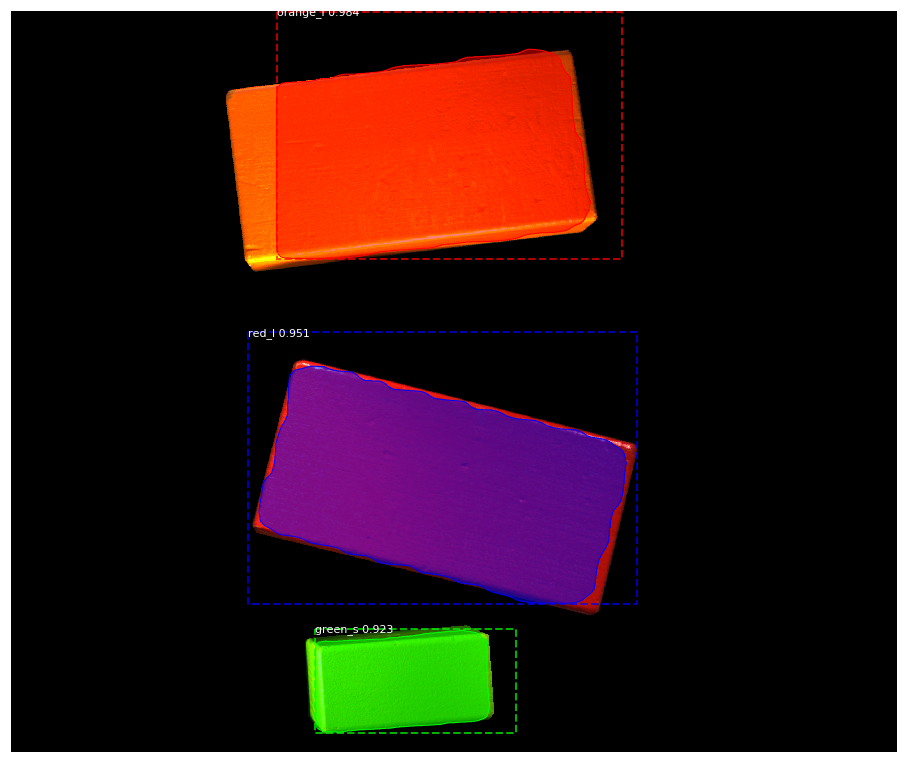

In [28]:
# -*- coding: utf-8 -*-
import os
import sys
import tensorflow as tf
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2
import time
import warnings
warnings.filterwarnings('ignore')
from mrcnn.config import Config
from datetime import datetime 

print(tf.__version__)
# Root directory of the project
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(MODEL_DIR ,"mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "dataset_generator/labeled_images/test")

class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 15  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 320
    IMAGE_MAX_DIM = 384

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8 * 6, 16 * 6, 32 * 6, 64 * 6, 128 * 6)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE =100

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 50

#class InferenceConfig(coco.CocoConfig):
class InferenceConfig(ShapesConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
class_names = ['BG', 'red_s','red_m','red_l','yellow_s','yellow_m','yellow_l','green_s','green_m','green_l','blue_s','blue_m','blue_l','orange_s','orange_m','orange_l']
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
a=datetime.now() 
# Run detection
results = model.detect([image], verbose=1)
b=datetime.now() 
# Visualize results
print("Time",(b-a).seconds)
r = results[0]
# print(r)
print(r['scores'])
print(r['class_ids'])

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [21]:
APs = []
for image_id in dataset_val.image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

KeyboardInterrupt: 